In [2]:
# https://gee-community-catalog.org/projects/annual_nlcd/#earth-engine-snippet
import ee
import xarray as xr
import pandas as pd
import numpy as np
import dask.array as da
import xee
from bbox import * 
from datetime import datetime
# Trigger the authentication flow
ee.Authenticate()

# Initialize the Earth Engine library
ee.Initialize(project='satellite-modeling')

# Define the rectangle that encompasses Louisiana and Texas
bbox = ee.Geometry.Rectangle([lon_min, lat_min, lon_max, lat_max])

start_date = '2023-07-01T00:00'
end_date = datetime.now().strftime('%Y-%m-%dT%H:%M')

In [3]:
no2_hours = pd.read_csv("../../data/tempo_data/no2_file_hours.csv")
no2_hours=list(no2_hours['time_hr_ct'])
time_list = np.array(no2_hours, dtype="datetime64[ns]")

In [4]:
##################################################
# Load RTMA Data
##################################################

# List of climate variables to download from NOAA RTMA
variables = ['LWGNT', 'SWGNT']
# Load NOAA hourly data and filter by region and date
dataset = ee.ImageCollection("NASA/GSFC/MERRA/rad/2") \
            .filterDate(start_date, end_date) \
            .filterBounds(bbox)  \
            .select(variables)

ds = xr.open_dataset(dataset, engine='ee', crs='EPSG:4326', scale=0.01)
# Filter the dataset based on the latitude and longitude bounds
ds = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

##################################################
# Change Timestamps
##################################################
# Recreate UTC Time Stamps
ds_time_list = ds["time"].values.tolist()
timestamps_utc = pd.to_datetime(ds_time_list)
timestamps_utc = timestamps_utc.tz_localize('UTC')

# Add 1 hour to each timestamp so that it contains weather data from prior hour
timestamps_adjusted = timestamps_utc + pd.Timedelta(hours=1)

# Convert to Central Time (handles daylight saving time automatically)
timestamps_central = timestamps_adjusted.tz_convert('America/Chicago')
timestamps_central = timestamps_central.tz_localize(None)
timestamps_central=np.array(timestamps_central, dtype="datetime64[ns]")
# Replace the time dimension
ds = ds.assign_coords(time=timestamps_central)

# Remove duplicate hour from time change
ds = ds.isel(time=ds.get_index("time").duplicated() == False)

In [5]:
# Find dates included in both sat and weather data
seta = set(timestamps_central)
setb = set(time_list)
union_set = seta & setb
full_time_list = list(union_set)
ds = ds.sel(time=full_time_list)
unique_months = sorted(set(date.astype('datetime64[M]') for date in full_time_list))

In [11]:
for i in range(4, len(unique_months)):
    print(i)
    month=unique_months[i]
    month_str=str(month)
    dates_in_month = [date for date in full_time_list if date.astype('datetime64[M]') == month]
    ds_month = ds.sel(time=dates_in_month)
    
    ds_month = ds_month.chunk({'time': 1}).persist()
    print('**')

    ds_month.to_netcdf(f'../../data/weather_data2/weather_data_{month_str}.nc', engine='h5netcdf')

array(['2023-08-02T10:00:00.000000000', '2023-08-02T11:00:00.000000000',
       '2023-08-02T12:00:00.000000000', ...,
       '2024-11-22T12:00:00.000000000', '2024-11-22T13:00:00.000000000',
       '2024-11-22T14:00:00.000000000'], dtype='datetime64[ns]')

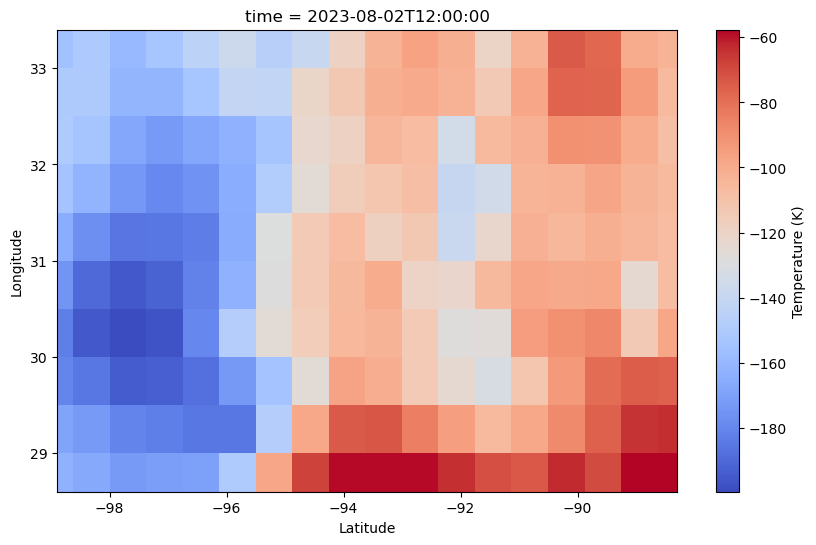

In [8]:
import matplotlib.pyplot as plt
# # Define your latitude and longitude bounds
# lat_min, lat_max = 28.6, 33.4  # Example latitude range
# lon_min, lon_max = -98.9, -88.3  # Example longitude range

# Select one hour of temperature data (e.g., the first timestamp)
hour_index = 0  # Change this to select a different hour if desired
temperature_data = ds['LWGNT'].isel(time=hour_index)
# temperature_data = ds['Percent_Tree_Cover']

# Plot the data with switched axes
plt.figure(figsize=(10, 6))

# Plot with latitude on x-axis and longitude on y-axis
temperature_data.T.plot(
    cmap="coolwarm",  # Colormap for temperature visualization
    cbar_kwargs={'label': 'Temperature (K)'}  # Add color bar label
)

# Update axis labels
plt.xlabel("Latitude")
plt.ylabel("Longitude")

plt.show()